# Designing a Python API to GraphBLAS and LAGraph

## Michel Pelletier

https://github.com/michelp/pygraphblas

https://github.com/michelp/pggraphblas

In [1]:
print("This is a Jupyter Notebook!!")

This is a Jupyter Notebook!!


In [2]:
import pygraphblas
print(len(dir(pygraphblas)))

1525


In [3]:
from pygraphblas import *
from pygraphblas.demo.gviz import draw, draw_op, draw_graph, draw_layers

In [4]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


# Matrices from Lists

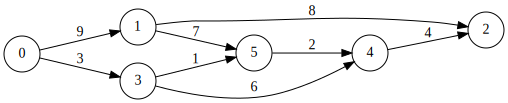

In [5]:
A = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 1, 5],
    [1, 3, 2, 4, 5, 2, 5, 4],
    [9, 3, 8, 6, 1, 4, 7, 2],)

draw(A)

# Random Graphs

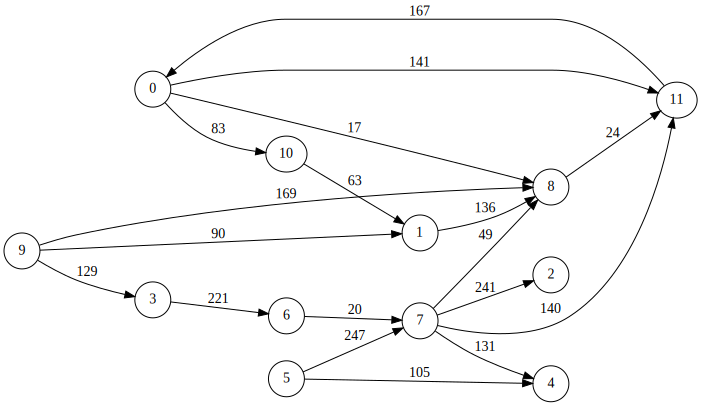

In [6]:
draw(Matrix.random(UINT8, 12,12,20, no_diagonal=True, seed=42), show_weight=True)

# Elementwise Addition

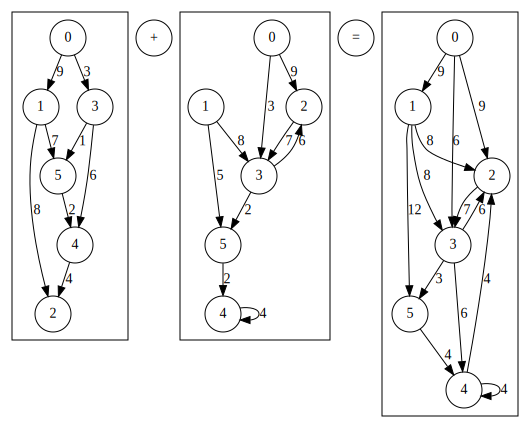

In [7]:
B = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 1, 5, 2],
    [2, 3, 3, 2, 5, 4, 5, 4, 3],
    [9, 3, 8, 6, 2, 4, 5, 2, 7],)

C = A + B
draw_op(A, '+', B, C)

# Elementwise Multiplication

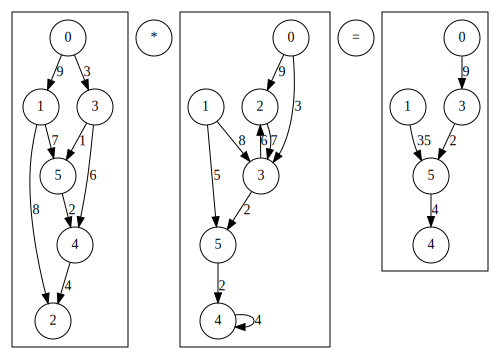

In [8]:
C = A * B
draw_op(A, '*', B, C)

# Using an Operator

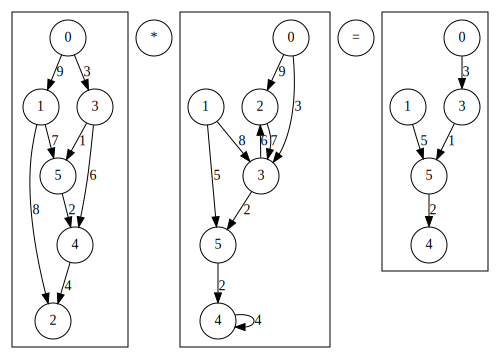

In [9]:
with min:
    C = A * B

draw_op(A, '*', B, C)

# Vector Matrix Multiplication

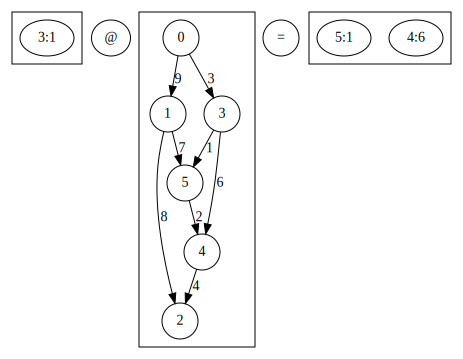

In [10]:
v = Vector.from_lists([3],[1], A.nrows)

y = v @ A
draw_op(v, '@', A, y)

# Matrix Vector Multiplication

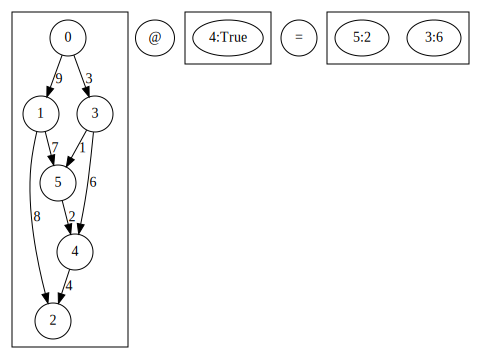

In [11]:
v = Vector.from_lists([4],[True], A.nrows)

y = A @ v
draw_op(A, '@', v, y)

# Matrix Matrix Multiplication

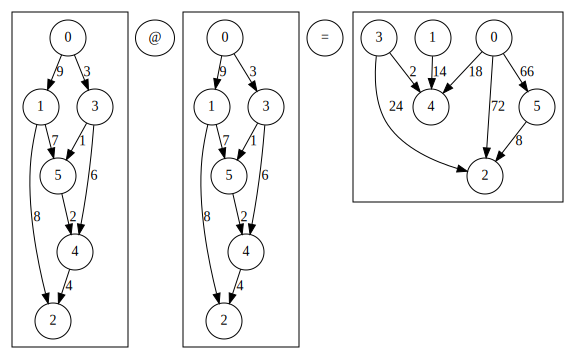

In [12]:
draw_op(A, '@', A, A @ A)

# Using a Semiring

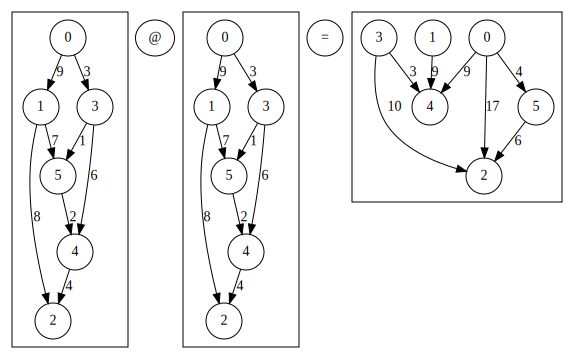

In [13]:
with min_plus:
    g = draw_op(A, '@', A, A @ A)
g

# Breadth First Search

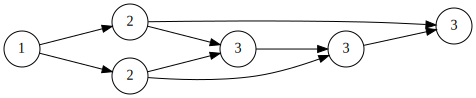

In [14]:
def bfs(matrix, start):
    """Given a graph and a starting position, return a vector of hops to all other nodes."""
    v = Vector.from_type(UINT8, matrix.nrows)   # the result vector
    q = Vector.from_type(BOOL, matrix.nrows)    # a vector to keep track of known nodes
    
    q[start] = True
    not_done = True
    level = 1
    
    while not_done and level <= matrix.nrows:
        v[:,q] = level                          # Assign the current level to known (q) nodes in v
        q = v.vxm(matrix, 
                  mask=v, 
                  desc=descriptor.ooco)         # compliment the mask only find the next unknown nodes
        not_done = q.reduce_bool()              # is q full?
        level += 1                              # increment level
    return v
    
draw(A, show_weight=False, label_vector=bfs(A, 0))

# Shortest Path Length

In [15]:
def shortest_path_length(matrix, start):
    v = Vector.from_type(matrix.type, matrix.nrows)
    v[start] = 0

    with min_plus, Accum(min):
        for _ in range(matrix.nrows):
            w = Vector.dup(v)
            v @= matrix
            if w.iseq(v):
                break
        return v

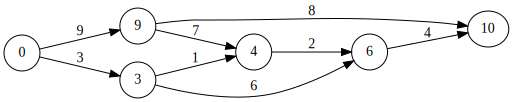

In [16]:
    draw(A, label_vector=shortest_path_length(A, 0))

# User Defined Types

In [17]:
from pygraphblas import *

class BF(Struct):
    
    members = ['double w', 'uint64_t h', 'uint64_t pi']
    identity = (lib.INFINITY, lib.UINT64_MAX, lib.UINT64_MAX)
    
    @binop(boolean=True) 
    def eq_op(z, x, y):
        if not x.w == y.w and x.h == y.h and x.pi == y.pi:
            z = True
        else:
            z = False

    @binop()
    def add_op(z, x, y):
        if (x.w < y.w 
            or x.w == y.w and x.h < y.h 
            or x.w == y.w and x.h == y.h and x.pi < y.pi):
            if (z.w != x.w and z.h != x.h and z.pi != x.pi):
                z.w = x.w
                z.h = x.h
                z.pi = x.pi        
        else:
            z.w = y.w
            z.h = y.h
            z.pi = y.pi   

    @binop()
    def mult_op(z, x, y):
        z.w = x.w + y.w
        z.h = x.h + y.h
        if x.pi != lib.UINT64_MAX and y.pi != 0:
            z.pi = y.pi
        else:
            z.pi = x.pi

In [18]:
def shortest_path(matrix, start):
    n = matrix.nrows
    v = Vector.from_type(matrix.type, n)
    for i, j, k in matrix:
        if i == j:
            matrix[i,j] = (0, 0, 0)
        else:
            matrix[i,j] = (k[0], 1, i)        
    v[start] = (0, 0, 0)
    with BF.semiring, Accum(BF.add_op):
        for _ in range(matrix.nrows):
            w = v.dup()
            v @= matrix
            if w.iseq(v):
                break
    return v

A = Matrix.from_type(BF, 6, 6)
A[0,1] = (9.0, 0, 0)
A[0,3] = (3.0, 0, 0)
A[1,2] = (8.0, 0, 0)
A[3,4] = (6.0, 0, 0)
A[3,5] = (1.0, 0, 0)
A[4,2] = (4.0, 0, 0)
A[1,5] = (7.0, 0, 0)
A[5,4] = (2.0, 0, 0)


# Materialized Shortest Path

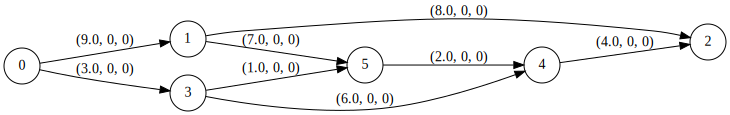

In [19]:
from pygraphblas.demo.gviz import draw
draw(A)

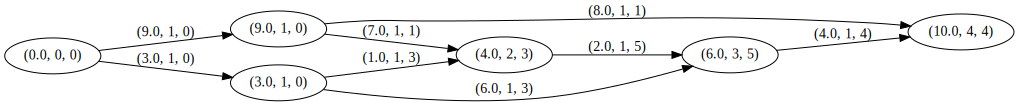

In [20]:
draw(A, label_vector=shortest_path(A, 0))

# PageRank

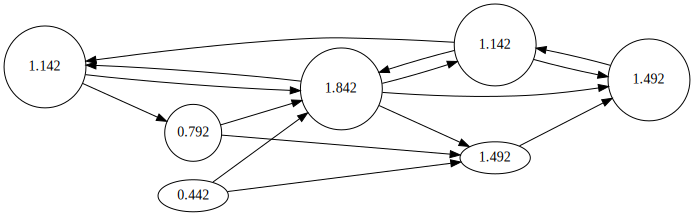

In [21]:
def pagerank(A, damping_factor, itermax):
    n = A.nrows
    d_out = A.reduce_vector()
    pr = Vector.from_type(FP32, n)
    pr[:] = 1.0/n
    teleport = (1 - damping_factor) / n
    for i in range(itermax):
        importance_vec = pr / d_out
        with Accum(times):
            importance_vec[:] = damping_factor
        importance_vec = A.transpose() @ importance_vec
        dangling_vec = pr[d_out]
        dangling_sum = dangling_vec.reduce_int() * (damping_factor / n)
        pr[:] = (teleport + dangling_sum)
        pr = pr + importance_vec
    return pr


M = Matrix.random(FP32, 7, 7, 30, no_diagonal=True, make_pattern=True, seed=42)

pr = pagerank(M, 0.35, 3)
draw(M, label_vector=pr, size_vector=pr, show_weight=False, label_width=5)

# Sparse Deep Neural Networks

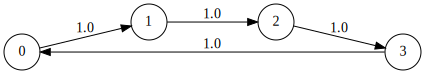

In [22]:
def permutation_matrix(size):
    P = Matrix.from_type(FP64, size, size)    
    P[size-1,0] = 1.0
    for i in range(size-1):
        P[i,i+1] = 1.0
    return P

draw_graph(permutation_matrix(4))

In [23]:
from functools import reduce
import operator

def mixed_topo_radix(topos):
    sizes = [reduce(operator.mul, x) for x in topos]
    size = sizes[0]
    layers = []
    P = permutation_matrix(size)
    
    for t in topos:
        place_value = 1
        for n in t:
            layer = Matrix.from_type(FP64, size, size)
            for j in range(n):
                layer += (P ** (j*place_value))
            place_value *= n
            layers.append(layer)      
    return layers

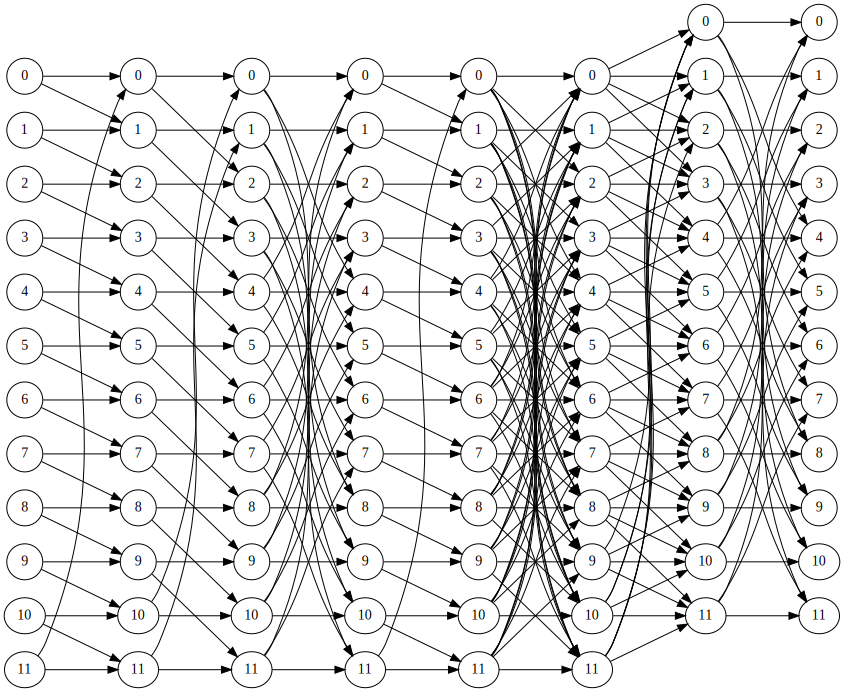

In [28]:
draw_layers(mixed_topo_radix([[2,2,3], [2,6], [4,3]]))

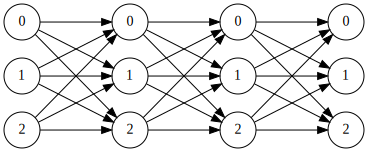

In [25]:
def ddnn(spec):
    return [Matrix.dense(FP64, spec[i], spec[i+1])
            for i in 
            range(len(spec) - 1)]

draw_layers(ddnn([3,3,3,3]))

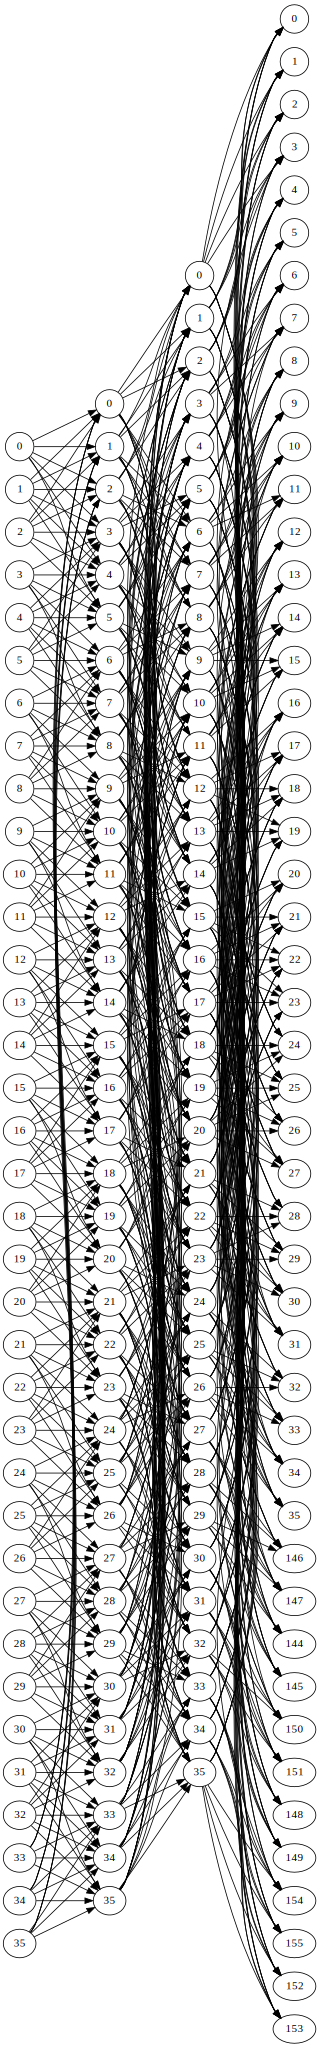

In [29]:
def radixnet(topos, spec):
    return [d.kron(w) 
            for d, w in 
            zip(mixed_topo_radix(topos), ddnn(spec))]

draw_layers(radixnet([[2,3,2]], [3,3,3,4])) 

# Forward Inference from DNN Challenge

In [27]:
def dnn(W, B, Y):
    for w, b in zip(W, B):
        Y = Y @ w
        with plus_plus:
            Y = Y @ b
        Y = Y.select('>0')
        M = Y.select('>', 32)
        if len(M):
            Y[M] = 32
    return Y

# Future Work